In [31]:
!pip install plotly



In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
import string
import plotly.express as px

In [2]:
# Load datasets
true = pd.read_csv('True.csv')
false = pd.read_csv('Fake.csv')

In [5]:
true.head(3)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


In [6]:
false.head(3)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"


In [7]:
true['category'] = 1
false['category'] = 0

df = pd.concat([true, false])

df.drop(columns=['title', 'subject', 'date'], inplace=True)




In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 23480
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      44898 non-null  object
 1   category  44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [10]:

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# Stemming function
stemmer = nltk.PorterStemmer()
def stem_text(text):
    return " ".join([stemmer.stem(word) for word in text.split() if word.lower() not in stop])

df['text'] = df['text'].apply(stem_text)


In [12]:
# Reduce dataset size for memory management
sample_size = 5000  # Adjust this number based on your available RAM
df = df.sample(n=sample_size, random_state=42)

In [13]:
# Splitting training and testing data
x_train, x_test, y_train, y_test = train_test_split(df.text, df.category, test_size=0.2, stratify=df.category, random_state=42)


In [14]:
# Vectorization with feature limits
cv = CountVectorizer(max_features=5000, ngram_range=(1, 2))
cv_train_reviews = cv.fit_transform(x_train)
cv_test_reviews = cv.transform(x_test)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_train_reviews = tfidf.fit_transform(x_train)
tfidf_test_reviews = tfidf.transform(x_test)

In [15]:
# Pad sequences to ensure consistent input length
max_length = 100
x_train_padded = pad_sequences(cv_train_reviews.toarray(), maxlen=max_length)
x_test_padded = pad_sequences(cv_test_reviews.toarray(), maxlen=max_length)

In [30]:
#Plot a graph to show if the data is balanced or not
category_counts = df['category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Use Plotly for an interactive and colorful bar chart
fig = px.bar(category_counts, x='Category', y='Count', title='Distribution of Categories',
             labels={'Category': 'Category', 'Count': 'Number of Samples'},
             color='Category', color_continuous_scale=px.colors.sequential.Viridis)

fig.show()

In [16]:
# Define models
def create_model_cnn(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=50, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
def create_model_lstm(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=50, input_length=input_dim))
    model.add(LSTM(50))
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [18]:
# Training and evaluating models
results = {}

In [20]:
# CNN Model
model_cnn = create_model_cnn(max_length)
model_cnn.fit(x_train_padded, y_train, epochs=10, batch_size=32, verbose=1)
pred_cnn = (model_cnn.predict(x_test_padded) > 0.5).astype("int32")
results['CNN Model'] = {
    'Accuracy': accuracy_score(y_test, pred_cnn),
    'Confusion Matrix': confusion_matrix(y_test, pred_cnn),
    'ROC Curve': roc_curve(y_test, model_cnn.predict(x_test_padded)),
    'Precision': precision_score(y_test, pred_cnn),
    'Recall': recall_score(y_test, pred_cnn),
    'F1 Score': f1_score(y_test, pred_cnn)
}

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5961 - loss: 0.6543
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6942 - loss: 0.5576
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7055 - loss: 0.5266
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7029 - loss: 0.5220
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7268 - loss: 0.5012
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7417 - loss: 0.4727
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7628 - loss: 0.4548
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7782 - loss: 0.4365
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7845 - loss: 0.4142
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8041 - loss: 0.3816
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [21]:
# LSTM Model
model_lstm = create_model_lstm(max_length)
model_lstm.fit(x_train_padded, y_train, epochs=10, batch_size=32, verbose=1)
pred_lstm = (model_lstm.predict(x_test_padded) > 0.5).astype("int32")
results['LSTM Model'] = {
    'Accuracy': accuracy_score(y_test, pred_lstm),
    'Confusion Matrix': confusion_matrix(y_test, pred_lstm),
    'ROC Curve': roc_curve(y_test, model_lstm.predict(x_test_padded)),
    'Precision': precision_score(y_test, pred_lstm),
    'Recall': recall_score(y_test, pred_lstm),
    'F1 Score': f1_score(y_test, pred_lstm)
}

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4966 - loss: 0.6935
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5180 - loss: 0.6930
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5374 - loss: 0.6890
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5284 - loss: 0.6784
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5617 - loss: 0.6725
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5617 - loss: 0.6693
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5631 - loss: 0.6691
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5560 - loss: 0.6725
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5865 - loss: 0.6603
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5736 - loss: 0.6619
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [22]:
# Collect results into lists
model_names = []
accuracies = []
roc_auc_scores = []
precisions = []
recalls = []
f1_scores = []

for name, metrics in results.items():
    model_names.append(name)
    accuracies.append(metrics['Accuracy'])

    # Ensure that the predictions and true labels have consistent lengths
    y_true = y_test
    y_scores = metrics['ROC Curve'][1]

    if len(y_true) == len(y_scores):
        roc_auc = roc_auc_score(y_true, y_scores)
    else:
        roc_auc = np.nan  # Handle the error case appropriately
        print(f"Warning: Length mismatch in ROC-AUC computation for {name}")

    roc_auc_scores.append(roc_auc)
    precisions.append(metrics['Precision'])
    recalls.append(metrics['Recall'])
    f1_scores.append(metrics['F1 Score'])

In [26]:
# Create a DataFrame from the collected results
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'ROC-AUC': roc_auc_scores,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

In [25]:
# Display the DataFrame
print(results_df)


        Model  Accuracy  ROC-AUC  Precision    Recall  F1 Score
0   CNN Model     0.698      NaN   0.663685  0.764948  0.710728
1  LSTM Model     0.571      NaN   0.551661  0.616495  0.582278


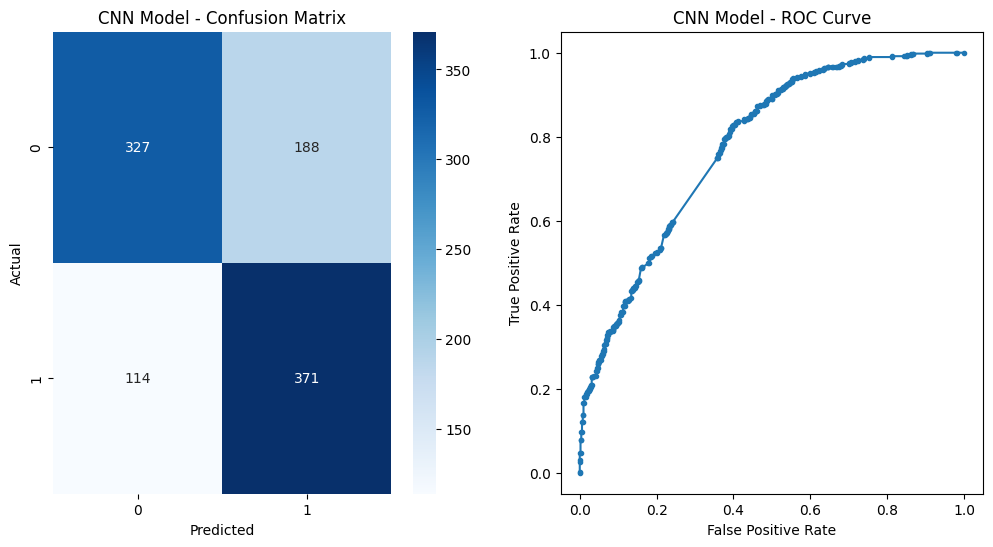

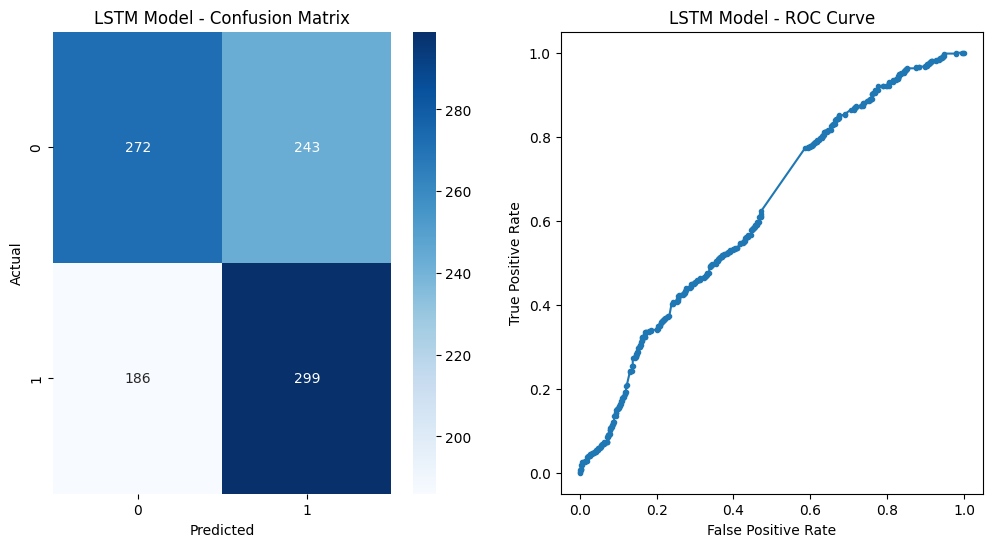

In [33]:
# Plot Confusion Matrices and ROC Curves
for name, metrics in results.items():
    cm = metrics['Confusion Matrix']
    fpr, tpr, _ = metrics['ROC Curve']

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, marker='.')
    plt.title(f'{name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()

In [34]:
# Manual Testing
manual_test_samples = df.sample(10, random_state=42)
manual_test_samples_text = manual_test_samples['text'].tolist()
manual_test_samples_labels = manual_test_samples['category'].tolist()

manual_test_samples_transformed = tfidf.transform(manual_test_samples_text)
manual_test_predictions = (model_lstm.predict(manual_test_samples_transformed) > 0.5).astype("int32")

for i, (text, label, prediction) in enumerate(zip(manual_test_samples_text, manual_test_samples_labels, manual_test_predictions)):
    print(f"Sample {i+1}")
    print(f"Text: {text[:200]}...")  # Print a snippet of the text
    print(f"Actual Label: {'True' if label == 1 else 'Fake'}")
    print(f"Predicted Label: {'True' if prediction == 1 else 'Fake'}")
    print("\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
Sample 1
Text: hanover, germani (reuters) - u.s. presid barack obama slip pair virtual realiti glass bedeck plastic googli eye muse someday use technolog talk daughter leav home college. display one mani stop two-ho...
Actual Label: True
Predicted Label: Fake


Sample 2
Text: yangon (reuters) - unit state temporarili suspend travel american offici part myanmar rakhin state, u.s. embassi said thursday, cite concern potenti protest secretari state rex tillerson accus myanmar...
Actual Label: True
Predicted Label: Fake


Sample 3
Text: arkansa woman went pick class ring order walmart left disappointed, store offici told retail new polici bar turn item bore imag confeder flag.elain glidewel told kfsm someon store fort smith call pick...
Actual Label: Fake
Predicted Label: Fake


Sample 4
Text: washington (reuters) - u.s. appeal court tuesday allow democrat state attorney gener defend subsidi payment insur compani obamacar healthcar law, critic part fu

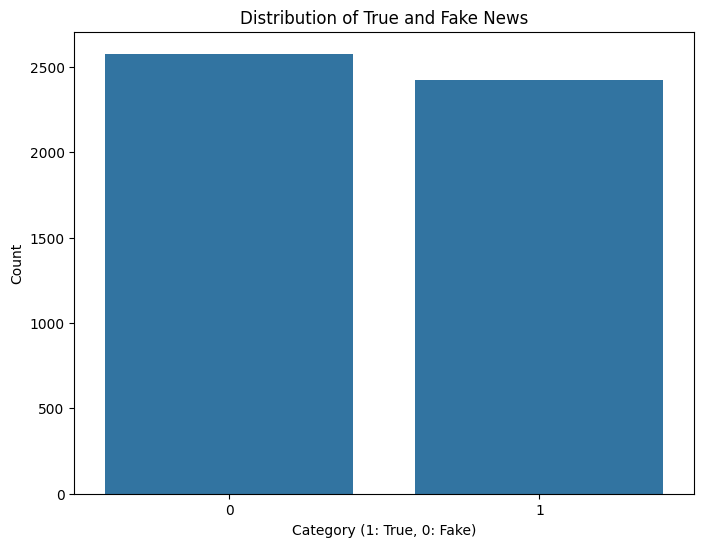

In [35]:
# Plot dataset distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='category', data=df)
plt.title("Distribution of True and Fake News")
plt.xlabel("Category (1: True, 0: Fake)")
plt.ylabel("Count")
plt.show()

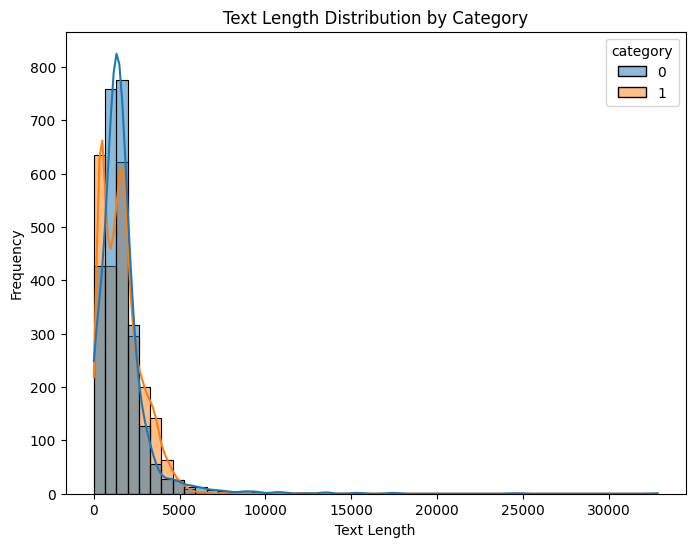

In [36]:
# Text Length Analysis
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='text_length', hue='category', bins=50, kde=True)
plt.title('Text Length Distribution by Category')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

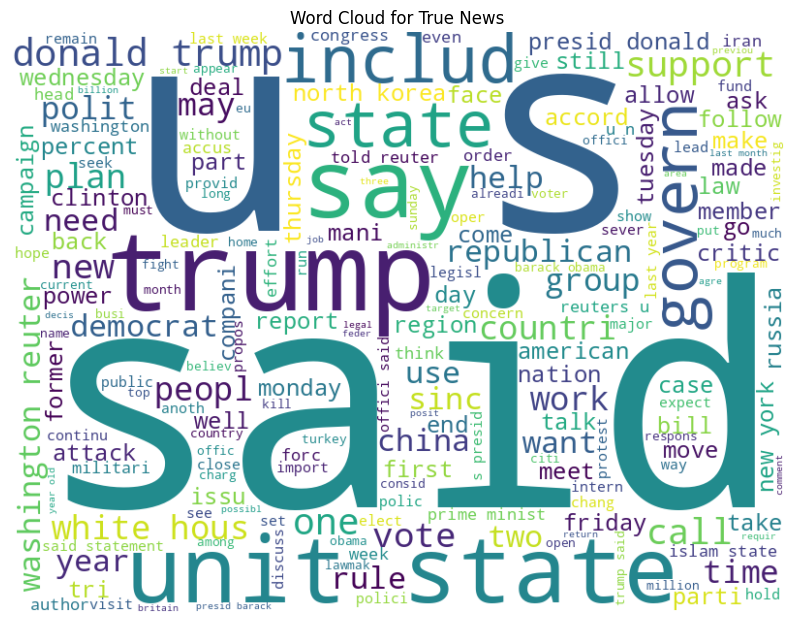

In [37]:
# Word Cloud for True News
true_words = ' '.join(df[df['category'] == 1]['text'])
wordcloud_true = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=600).generate(true_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.title('Word Cloud for True News')
plt.axis('off')
plt.show()

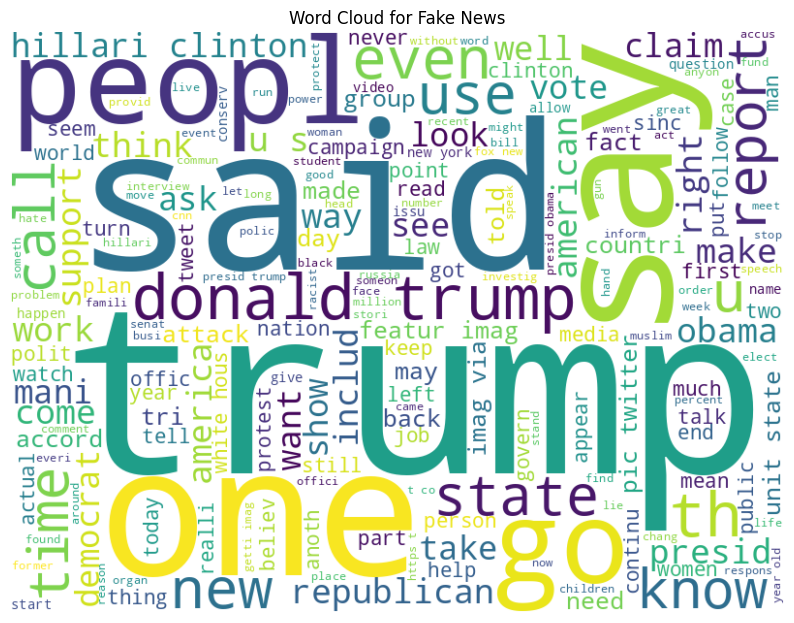

In [38]:
# Word Cloud for Fake News
fake_words = ' '.join(df[df['category'] == 0]['text'])
wordcloud_fake = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=600).generate(fake_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Word Cloud for Fake News')
plt.axis('off')
plt.show()

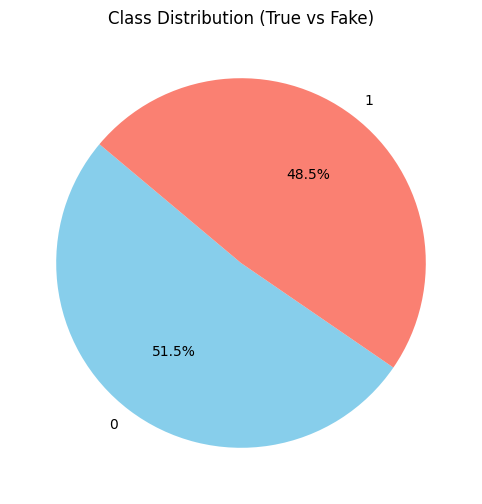

In [39]:
# Pie chart for class distribution
plt.figure(figsize=(8, 6))
df['category'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=140)
plt.title('Class Distribution (True vs Fake)')
plt.ylabel('')
plt.show()

<ipython-input-40-77de35426edb>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




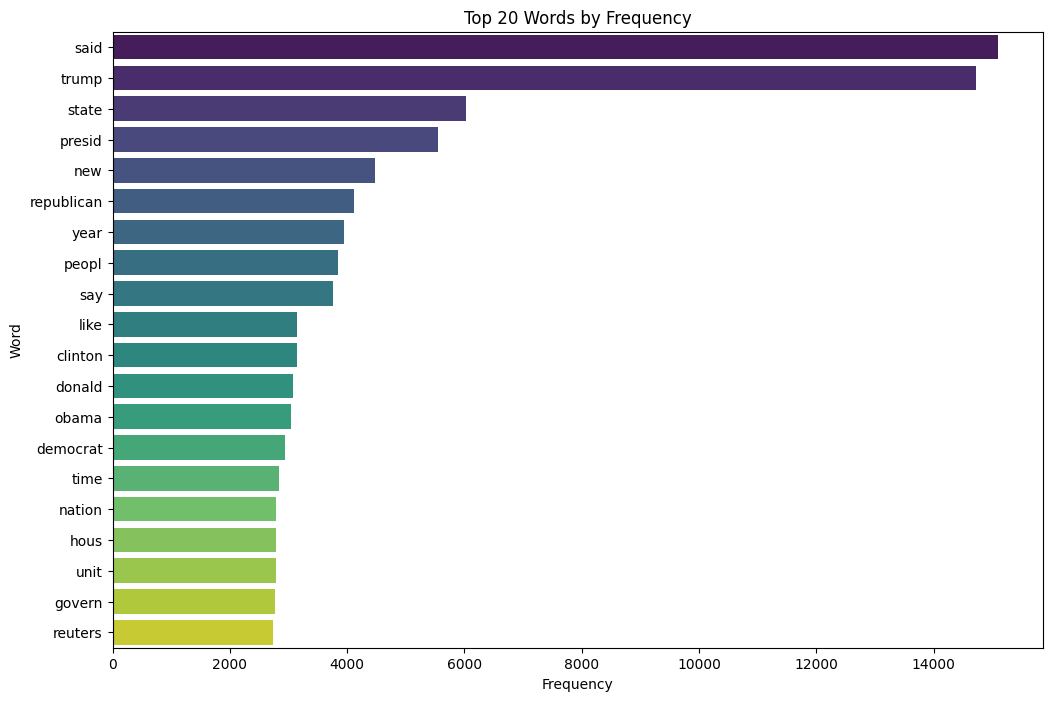

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract words and their frequencies
vectorizer = CountVectorizer(stop_words='english', max_features=50)
X = vectorizer.fit_transform(df['text'])
word_freq = np.asarray(X.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()

# Create a DataFrame
word_freq_df = pd.DataFrame({'Word': words, 'Frequency': word_freq})
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Plot the top 20 words
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=word_freq_df.head(20), palette='viridis')
plt.title('Top 20 Words by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


<ipython-input-41-c5a1ab5e7a14>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




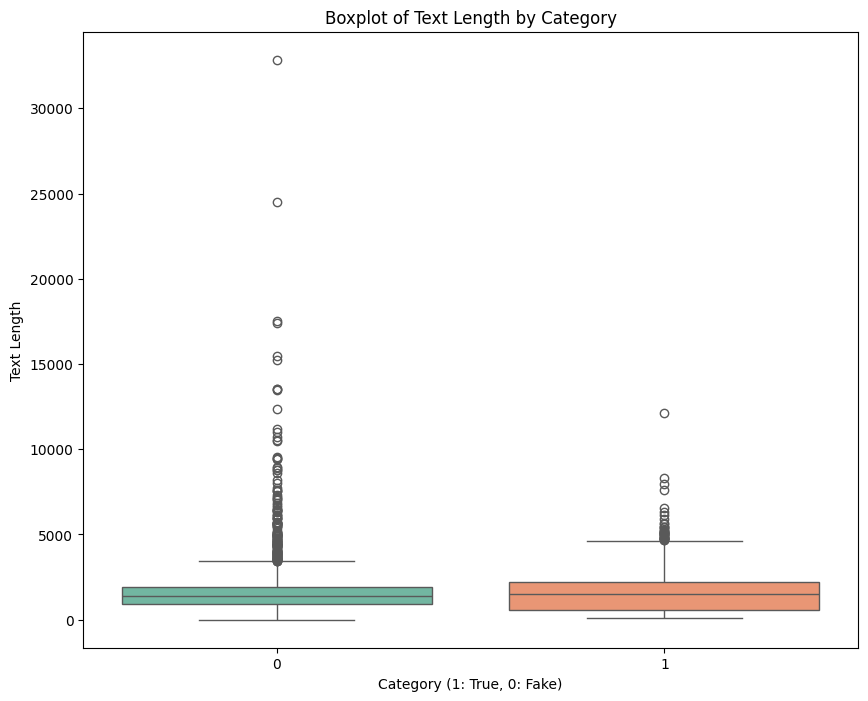

In [41]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='category', y='text_length', data=df, palette='Set2')
plt.title('Boxplot of Text Length by Category')
plt.xlabel('Category (1: True, 0: Fake)')
plt.ylabel('Text Length')
plt.show()